In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#import the data
mimic_path='/Users/jieche/Desktop/machine learning/mimic-iv-2.2/'

In [3]:
#Begin with admission data
admits = pd.read_csv(mimic_path + 'hosp/admissions.csv.gz', compression='gzip')
admits.head()


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [4]:
#Only keep the useful information for analysis.
admits = admits[['subject_id', 'hadm_id', 'race']]
admits.head()


,subject_id,hadm_id,race
0,10000032,22595853,WHITE
1,10000032,22841357,WHITE
2,10000032,25742920,WHITE
3,10000032,29079034,WHITE
4,10000068,25022803,WHITE


In [5]:
#Simplify the data
admits['race'].value_counts()


WHITE                                        272932
BLACK/AFRICAN AMERICAN                        59959
OTHER                                         15102
UNKNOWN                                       10668
HISPANIC/LATINO - PUERTO RICAN                 8076
WHITE - OTHER EUROPEAN                         7925
HISPANIC OR LATINO                             7754
ASIAN                                          6156
ASIAN - CHINESE                                5587
WHITE - RUSSIAN                                5024
BLACK/CAPE VERDEAN                             4765
HISPANIC/LATINO - DOMINICAN                    4383
BLACK/CARIBBEAN ISLAND                         2704
BLACK/AFRICAN                                  2530
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
ASIAN - SOUTH EAST ASIAN                       1446
HISPANIC/LATINO - GUATEMALAN                   1330
ASIAN - ASIA

In [6]:
import re

# 将所有以"white"开头的字符串替换为"white"
admits['race'] = admits['race'].apply(
    lambda x: re.sub(r'^WHITE.*', 'WHITE', str(x)))
admits['race'] = admits['race'].apply(
    lambda x: re.sub(r'^BLACK.*', 'BLACK', str(x)))
admits['race'] = admits['race'].apply(
    lambda x: re.sub(r'^ASIAN.*', 'ASIAN', str(x)))
admits['race'] = admits['race'].apply(
    lambda x: re.sub(r'^HISPANIC.*', 'HISPANIC', str(x)))
admits['race'].value_counts()


WHITE                                        288154
BLACK                                         69958
HISPANIC                                      25212
OTHER                                         15102
ASIAN                                         14893
UNKNOWN                                       10668
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
AMERICAN INDIAN/ALASKA NATIVE                   919
MULTIPLE RACE/ETHNICITY                         560
SOUTH AMERICAN                                  505
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       386
Name: race, dtype: int64

In [7]:
# put the others in the same category: other/unknown
admits['race'].loc[~admits['race'].isin(
    admits['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
admits['race'].value_counts()


/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_14915/2112628393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admits['race'].loc[~admits['race'].isin(


WHITE            288154
BLACK             69958
HISPANIC          25212
OTHER/UNKNOWN     17912
OTHER             15102
ASIAN             14893
Name: race, dtype: int64

In [8]:
admits['race'].replace(
    ['OTHER/UNKNOWN', 'OTHER'], value='OTHER/UNKNOWN', inplace=True)
admits['race'].value_counts()


WHITE            288154
BLACK             69958
OTHER/UNKNOWN     33014
HISPANIC          25212
ASIAN             14893
Name: race, dtype: int64

In [16]:
# patient
patients = pd.read_csv(mimic_path + 'hosp/patients.csv.gz', compression='gzip')
patients.head()


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [17]:
#Only keep id, gender, and age
patients = patients[['subject_id', 'gender','anchor_age']]
patients.head()


,subject_id,gender,anchor_age
0,10000032,F,52
1,10000048,F,23
2,10000068,F,19
3,10000084,M,72
4,10000102,F,27


In [18]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   subject_id  299712 non-null  int64 
 1   gender      299712 non-null  object
 2   anchor_age  299712 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.9+ MB


In [19]:
patients.anchor_age.describe()


count    299712.000000
mean         48.539888
std          20.895650
min          18.000000
25%          29.000000
50%          48.000000
75%          65.000000
max          91.000000
Name: anchor_age, dtype: float64

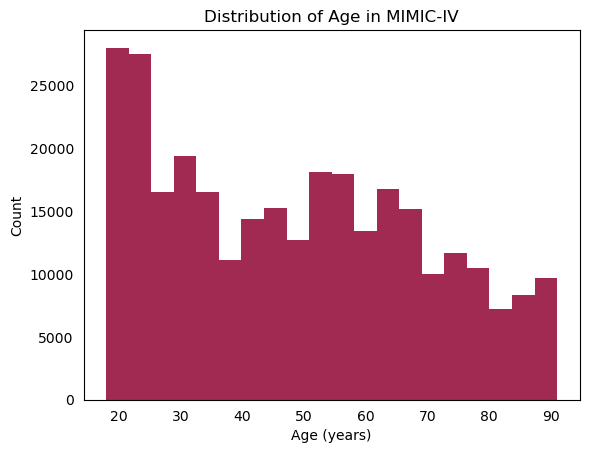

In [20]:
plt.hist(patients['anchor_age'], bins=20, color='#a12a52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show()


In [21]:
patients['gender'].value_counts()


F    158553
M    141159
Name: gender, dtype: int64

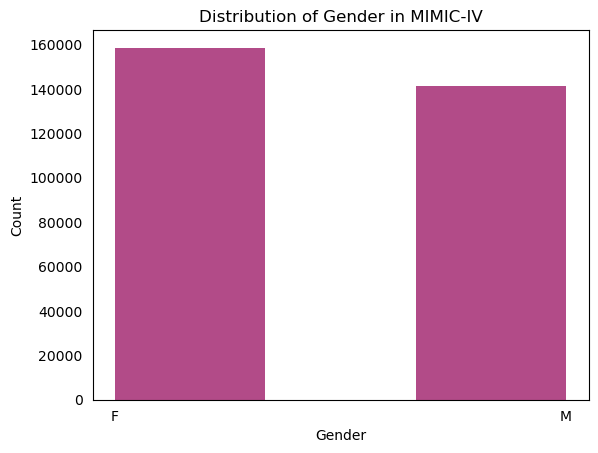

In [22]:
# distribution of gender
plt.hist(patients['gender'], bins=3, color='#b24b88')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Distribution of Gender in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show()


In [23]:
# merge the PATIENTS table with ADMISSIONS table
admits_patients = pd.merge(admits, patients, how='inner', on='subject_id')
admits_patients.head()


,subject_id,hadm_id,race,gender,anchor_age
0,10000032,22595853,WHITE,F,52
1,10000032,22841357,WHITE,F,52
2,10000032,25742920,WHITE,F,52
3,10000032,29079034,WHITE,F,52
4,10000068,25022803,WHITE,F,19


diagnoses，Change the icd10 code to icd9, as I had done in the project of readmission prediction. I have the csv file which contains the transferred file. And read it directly.

In [24]:
diag_icds = pd.read_csv('diag_icds_transfer.csv')

diag_icds.columns = diag_icds.iloc[0]
diag_icds = diag_icds.iloc[1:].reset_index(drop=True)

diag_icds.head()


/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_14915/2406960701.py:1: DtypeWarning: Columns (0,1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  diag_icds = pd.read_csv('diag_icds_transfer.csv')


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [25]:
diag_icds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   object
 1   hadm_id      object
 2   seq_num      object
 3   icd_code     object
 4   icd_version  object
dtypes: object(5)
memory usage: 181.4+ MB


In [26]:
# The code is stored as object, change the datatype to int64
diag_icds['subject_id'] = diag_icds['subject_id'].astype('int64')
diag_icds['hadm_id'] = diag_icds['hadm_id'].astype('int64')
diag_icds['seq_num'] = diag_icds['seq_num'].astype('int64')
diag_icds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  object
dtypes: int64(3), object(2)
memory usage: 181.4+ MB


In [27]:
# Filter out E and V codes from ICD9 codes since processing will be done on the numeric first 3 values
diag_icds['recode'] = diag_icds['icd_code']
diag_icds['recode'] = diag_icds['recode'][~diag_icds['recode'].str.contains(
    "[a-zA-Z]").fillna(False)]
diag_icds['recode'].fillna(value='999', inplace=True)

# Take in consideration just the first 3 integers of the ICD9 code
diag_icds['recode'] = diag_icds['recode'].str.slice(start=0, stop=3, step=1)
diag_icds['recode'] = diag_icds['recode'].astype(int)
diag_icds.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version,recode
0,10000032,22595853,1,5723,9,572
1,10000032,22595853,2,78959,9,789
2,10000032,22595853,3,5715,9,571
3,10000032,22595853,4,07070,9,70
4,10000032,22595853,5,496,9,496


In [28]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580,
                                                    630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diag_icds['recode'] = np.where(diag_icds['recode'].between(
        cat_range[0], cat_range[1]), num, diag_icds['recode'])

# Convert integer to category name using diag_dict
diag_icds['super_category'] = diag_icds['recode'].replace(diag_dict)
diag_icds.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,super_category
0,10000032,22595853,1,5723,9,8,digestive
1,10000032,22595853,2,78959,9,15,misc
2,10000032,22595853,3,5715,9,8,digestive
3,10000032,22595853,4,07070,9,0,infectious
4,10000032,22595853,5,496,9,7,respiratory


In [29]:
# Create list of diagnoses for each admission
hadm_list = diag_icds.groupby(
    'hadm_id')['super_category'].apply(list).reset_index()
hadm_list.head()


,hadm_id,super_category
0,20000019,"[infectious, genitourinary, congenital, genito..."
1,20000024,"[injury, injury, injury, injury, injury, injur..."
2,20000034,"[injury, injury, injury, injury, injury, injur..."
3,20000041,"[muscular, endocrine, injury, circulatory, end..."
4,20000057,"[muscular, muscular, injury, injury, injury, r..."


In [30]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(
    hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()


/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_14915/1190710123.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  hadm_item = pd.get_dummies(


,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,1,1,1,0,3,2,1,2,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0
3,0,1,0,1,3,0,0,4,0,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,7,0,1,5,0,4,0,1,2,0


In [31]:
# Join back with HADM_ID
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")


In [32]:
# Merge with main dataframe
admits_patients_diag = pd.merge(admits_patients, hadm_item, how='inner', on='hadm_id')
admits_patients_diag.head()

,subject_id,hadm_id,race,gender,anchor_age,blood,circulatory,congenital,digestive,endocrine,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,WHITE,F,52,0,0,0,2,0,...,1,2,1,0,0,0,0,0,1,0
1,10000032,22841357,WHITE,F,52,1,0,0,1,1,...,1,1,1,0,0,0,0,0,1,0
2,10000032,25742920,WHITE,F,52,0,0,0,1,2,...,2,1,2,0,0,0,0,0,1,0
3,10000032,29079034,WHITE,F,52,0,1,0,1,2,...,3,2,2,0,0,0,0,0,1,0
4,10000068,25022803,WHITE,F,19,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [33]:
admits_patients_diag.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 430852 entries, 0 to 430851
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   subject_id     430852 non-null  int64 
 1   hadm_id        430852 non-null  int64 
 2   race           430852 non-null  object
 3   gender         430852 non-null  object
 4   anchor_age     430852 non-null  int64 
 5   blood          430852 non-null  uint8 
 6   circulatory    430852 non-null  uint8 
 7   congenital     430852 non-null  uint8 
 8   digestive      430852 non-null  uint8 
 9   endocrine      430852 non-null  uint8 
 10  genitourinary  430852 non-null  uint8 
 11  infectious     430852 non-null  uint8 
 12  injury         430852 non-null  uint8 
 13  mental         430852 non-null  uint8 
 14  misc           430852 non-null  uint8 
 15  muscular       430852 non-null  uint8 
 16  neoplasms      430852 non-null  uint8 
 17  nervous        430852 non-null  uint8 
 18  preg

omr data

In [34]:
omr = pd.read_csv(mimic_path + 'hosp/omr.csv.gz', compression='gzip')
omr.head()


,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
1,10000032,2180-04-27,1,Weight (Lbs),94
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
3,10000032,2180-05-07,1,Height (Inches),60
4,10000032,2180-05-07,1,Weight (Lbs),92.15


In [35]:
omr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6439169 entries, 0 to 6439168
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   subject_id    int64 
 1   chartdate     object
 2   seq_num       int64 
 3   result_name   object
 4   result_value  object
dtypes: int64(2), object(3)
memory usage: 245.6+ MB


In [36]:
omr.result_name.value_counts()


Blood Pressure                      2169549
Weight (Lbs)                        1889542
BMI (kg/m2)                         1662112
Height (Inches)                      706906
Blood Pressure Sitting                 3400
Blood Pressure Lying                   2764
Blood Pressure Standing (1 min)        2560
Blood Pressure Standing (3 mins)        626
BMI                                     554
Blood Pressure Standing                 523
Weight                                  354
eGFR                                    240
Height                                   39
Name: result_name, dtype: int64

In [37]:
omr_bmi_bp = omr[(omr['result_name'] == 'Blood Pressure')
                 | (omr['result_name'] == 'BMI (kg/m2)')]


In [38]:
omr_bmi_bp.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
21,10000032,2180-05-25,1,Blood Pressure,106/60
22,10000032,2180-05-25,1,BMI (kg/m2),18.6
24,10000032,2180-06-01,1,Blood Pressure,121/77


In [42]:
omr_bmi_bp.result_name.value_counts()

Blood Pressure    2169549
BMI (kg/m2)       1662112
Name: result_name, dtype: int64

In [44]:
omr_pivot = omr_bmi_bp.pivot_table(
    index=['subject_id', 'chartdate'], columns='result_name', values='result_value', aggfunc='first').reset_index()


In [45]:
omr_pivot.head()

result_name,subject_id,chartdate,BMI (kg/m2),Blood Pressure
0,10000032,2180-04-27,NaN,110/65
1,10000032,2180-05-07,18.0,NaN
2,10000032,2180-05-25,18.6,106/60
3,10000032,2180-06-01,18.7,121/77
4,10000032,2180-06-22,18.9,100/60


In [46]:
# Split blood pressure column into systolic and diastolic pressure columns
omr_pivot[['Systolic_BP', 'Diastolic_BP']
               ] = omr_pivot['Blood Pressure'].str.split('/', expand=True)

# Convert systolic and diastolic pressure columns to numeric
omr_pivot['Systolic_BP'] = pd.to_numeric(omr_pivot['Systolic_BP'])
omr_pivot['Diastolic_BP'] = pd.to_numeric(omr_pivot['Diastolic_BP'])

omr_pivot = omr_pivot.rename(columns={'BMI (kg/m2)': 'BMI'})


In [47]:
# Convert BMI column to numeric
omr_pivot['BMI'] = pd.to_numeric(omr_pivot['BMI'])

In [48]:
omr_pivot.head()

result_name,subject_id,chartdate,BMI,Blood Pressure,Systolic_BP,Diastolic_BP
0,10000032,2180-04-27,NaN,110/65,110.0,65.0
1,10000032,2180-05-07,18.0,NaN,NaN,NaN
2,10000032,2180-05-25,18.6,106/60,106.0,60.0
3,10000032,2180-06-01,18.7,121/77,121.0,77.0
4,10000032,2180-06-22,18.9,100/60,100.0,60.0


In [49]:
omr_pivot=omr_pivot.drop(['Blood Pressure'], axis=1)

In [50]:
omr_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253388 entries, 0 to 2253387
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   subject_id    int64  
 1   chartdate     object 
 2   BMI           float64
 3   Systolic_BP   float64
 4   Diastolic_BP  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 86.0+ MB


In [51]:
omr_pivot.to_csv("omr_result.csv.gz", compression="gzip", index=False)

In [52]:
admits_patients_diag_omr = pd.merge(
    admits_patients_diag, omr_pivot, on='subject_id', how='inner')


In [53]:
admits_patients_diag_omr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11023399 entries, 0 to 11023398
Data columns (total 26 columns):
 #   Column         Dtype  
---  ------         -----  
 0   subject_id     int64  
 1   hadm_id        int64  
 2   race           object 
 3   gender         object 
 4   anchor_age     int64  
 5   blood          uint8  
 6   circulatory    uint8  
 7   congenital     uint8  
 8   digestive      uint8  
 9   endocrine      uint8  
 10  genitourinary  uint8  
 11  infectious     uint8  
 12  injury         uint8  
 13  mental         uint8  
 14  misc           uint8  
 15  muscular       uint8  
 16  neoplasms      uint8  
 17  nervous        uint8  
 18  pregnancy      uint8  
 19  prenatal       uint8  
 20  respiratory    uint8  
 21  skin           uint8  
 22  chartdate      object 
 23  BMI            float64
 24  Systolic_BP    float64
 25  Diastolic_BP   float64
dtypes: float64(3), int64(3), object(3), uint8(17)
memory usage: 1019.7+ MB


In [54]:
admits_patients_diag_omr.head()

,subject_id,hadm_id,race,gender,anchor_age,blood,circulatory,congenital,digestive,endocrine,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,chartdate,BMI,Systolic_BP,Diastolic_BP
0,10000032,22595853,WHITE,F,52,0,0,0,2,0,...,0,0,0,0,1,0,2180-04-27,NaN,110.0,65.0
1,10000032,22595853,WHITE,F,52,0,0,0,2,0,...,0,0,0,0,1,0,2180-05-07,18.0,NaN,NaN
2,10000032,22595853,WHITE,F,52,0,0,0,2,0,...,0,0,0,0,1,0,2180-05-25,18.6,106.0,60.0
3,10000032,22595853,WHITE,F,52,0,0,0,2,0,...,0,0,0,0,1,0,2180-06-01,18.7,121.0,77.0
4,10000032,22595853,WHITE,F,52,0,0,0,2,0,...,0,0,0,0,1,0,2180-06-22,18.9,100.0,60.0


In [55]:
admits_patients_diag_omr.to_csv('admits_patients_diag_omr.csv.gz',compression='gzip', index=False)